## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, I will be working to understand the results of an A/B test run by an e-commerce website. The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. My goal is to work through this notebook to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [42]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [44]:
df = pd.read_csv("ab_data.csv")
df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


b. Use the below cell to find the number of rows in the dataset.

In [45]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [46]:
df['user_id'].unique().size

290584

d. The proportion of users converted.

In [47]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [48]:
df.query('(group == "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page == "new_page")').shape[0]


3893

f. Do any of the rows have missing values?

In [50]:
df.isnull().any() #No missing values

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [51]:
df2 = df.drop(df.query('(group == "treatment" and landing_page != "new_page") or (group == "control" and landing_page != "old_page")').index)

In [52]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [53]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [54]:
df2['user_id'].unique().size

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [55]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [56]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [57]:
df2 = df2.drop(df2[df2.duplicated(['user_id'], keep='first')].index)

In [58]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [59]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [62]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [63]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [64]:
df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Your answer goes here.**

No, there's not sufficient evidence to say that the new treatment page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**


$$H_0: p_{new} <= p_{old}$$

$$H_1: p_{new} > p_{old} $$



`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [65]:
convert_rate_p_new = df2['converted'].mean()
convert_rate_p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [66]:
convert_rate_p_old = df2['converted'].mean()
convert_rate_p_old

0.11959708724499628

c. What is $n_{new}$?

In [67]:
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [69]:
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [70]:
new_page_converted = np.random.binomial(1, convert_rate_p_new, n_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [71]:
old_page_converted = np.random.binomial(1, convert_rate_p_old, n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [72]:
new_page_converted.mean() - old_page_converted.mean()

0.0014707907969722794

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [73]:
p_diffs = []

for i in range(10000):
    new = np.random.binomial(1, convert_rate_p_new, n_new)
    old = np.random.binomial(1, convert_rate_p_old, n_old)
    diff =  new.mean() - old.mean()
    p_diffs.append(diff)
    

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([1.000e+00, 5.000e+00, 1.080e+02, 6.830e+02, 2.012e+03, 3.199e+03,
        2.675e+03, 1.071e+03, 2.190e+02, 2.700e+01]),
 array([-0.00572174, -0.00471134, -0.00370094, -0.00269054, -0.00168014,
        -0.00066974,  0.00034067,  0.00135107,  0.00236147,  0.00337187,
         0.00438227]),
 <a list of 10 Patch objects>)

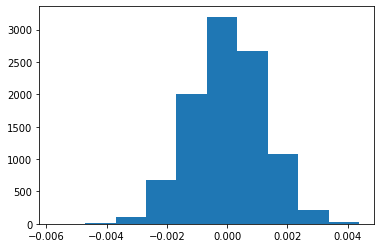

In [74]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [76]:
#observed difference
o_diffs = df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()
o_diffs

-0.0015782389853555567

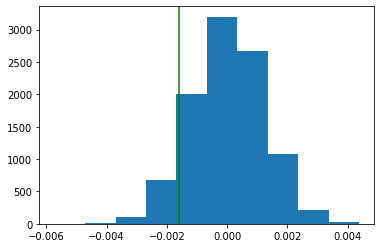

In [77]:
plt.hist(p_diffs)
plt.axvline(x=o_diffs, color = 'green')

In [78]:
#p_value
(p_diffs > o_diffs).mean() 

0.9098

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

Based on the alternative hypothesis $H_1: p_{new} > p_{old}$, we can see the p-value(0.9098) is larger than Type I error threshold(0.05). Because of the high p-value, we fail to reject the null hypothesis. We do not have statistically significant evidence to suggest that the new page converts are better.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [79]:
import statsmodels.api as sm

convert_old = df2.query("landing_page == 'old_page'")['converted'].sum()
convert_new = df2.query("landing_page == 'new_page'")['converted'].sum()
n_old = df2.query("landing_page == 'old_page'")['converted'].shape[0]
n_new = df2.query("landing_page == 'new_page'")['converted'].shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [80]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

We choose alternative='smaller' for proportions_ztest because our $H_1: p_{new} > p_{old} $. Z-score(1.3109) is a measure of how many standard deviations below or above the population mean a raw score is. A positive score means the null hypothesis is above the mean. P-value is very close with a p-value in parts j. and k. Because of the high p-value, we fail to reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

I think we should choose logistic regression because it is used to predict only two possible outcomes(conversion or no conversion). 

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [81]:
df2['intercept'] = 1
df2[['c_page', 'ab_page']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,c_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [89]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [90]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 04 Oct 2020   Pseudo R-squ.:               8.077e-06
Time:                        16:58:39   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The null and alternative hypotheses associated with regression model is: 
$$H_0: parameter = p_{old}$$

$$H_1: parameter != p_{old} $$

The p-value associated with the ab_page is 0.190, which is larger than the 0.05 type I error threshold, so it is not statistically significant to predict the conversion. On the other hand, the intercept(old page) with a p-value is 0.00, so it is statically significant to predict the conversion.
Also, the ab_page p-value is different from the value we found in Part II(0.9098) because logistic regression is a two-tailed test, while Part II is a one-tailed test.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

It's a good idea to consider other factors to add into the regression model to predict better. The disadvantage of adding those terms into the regression model is we can run into multicollinearity. We have to adjust our regression model to fit high order terms to avoid errors.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [91]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [92]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,c_page,ab_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [98]:
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [99]:
### Create the necessary dummy variables
df_new[['ca', 'uk', 'us']] = pd.get_dummies(df_new['country'])

In [100]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,c_page,ab_page,ca,uk,us
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


In [120]:
logit_mod_new = sm.Logit(df_new['converted'], df_new[['intercept', 'uk', 'us']])
results_new = logit_mod_new.fit()
results_new.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 04 Oct 2020   Pseudo R-squ.:               1.521e-05
Time:                        21:38:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
uk             0.0507      0.028      1.786      0.074      -0.005       0.106
us             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

In [123]:
#Interpretation
1/np.exp(0.0507), 1/np.exp(0.0408)

(0.9505637969004034, 0.9600211149716509)

We can see that the UK is 0.95 more likely to convert than CA, and the US is 0.96 more likely to convert than CA. Because the UK page has a lower p-value, I think we should adjust our model a bit by choosing CA and the UK.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [107]:
### Fit Your Linear Model And Obtain the Results
df_new['ca_new'] = df_new['ab_page']*df_new['ca']
df_new['uk_new'] = df_new['ab_page']*df_new['uk']
df_new['us_new'] = df_new['ab_page']*df_new['us']

In [108]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,c_page,ab_page,ca,uk,us,ca_new,uk_new,us_new
user_id,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,0,1,0


In [124]:
logit_mod_newer = sm.Logit(df_new['converted'], df_new[['intercept', 'ca_new', 'uk_new']])
results_newer = logit_mod_newer.fit()
results_newer.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 04 Oct 2020   Pseudo R-squ.:               2.364e-05
Time:                        21:48:53   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.08085
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9963      0.006   -322.049      0.000      -2.008      -1.984
ca_new        -0.0752      0.038     -1.997      0.046      -0.149      -0.001
uk_new         0.0149      0.017      0.862      0.389      -0.019       0.049
==============================================================================
"""

In [125]:
#Interpretation
1/np.exp(-0.0752), 1/np.exp(0.0149)

(1.0780997492739288, 0.9852104557227469)

We can see that the CA is 1.078 less likely to convert than the US, and the UK is 0.0149 more likely to convert than the US. Because the CA page has a lower p-value(0.046), I think it is statically significant less likely to convert compared to US and UK pages. I don't think countries have much impact on conversions based on those p-values and correlations. So I think we should keep the old page(fail to reject the null hypothesis).

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 